In [514]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import load_model

df = pd.read_csv('cbsl_new.csv', index_col='Date', parse_dates=True)


print(df)

            consumption
Date                   
2011-01-01        778.0
2011-02-01        783.0
2011-03-01        789.0
2011-04-01        804.0
2011-05-01        842.0
...                 ...
2022-05-01       1261.0
2022-06-01       1240.0
2022-07-01       1151.0
2022-08-01       1267.0
2022-09-01       1199.0

[141 rows x 1 columns]


In [515]:
# df = pd.read_csv('AK.csv',index_col='date',parse_dates=True)
df.index.freq='MS'

In [516]:
df.head()

,consumption
Date,
2011-01-01,778.0
2011-02-01,783.0
2011-03-01,789.0
2011-04-01,804.0
2011-05-01,842.0


<AxesSubplot:xlabel='Date'>

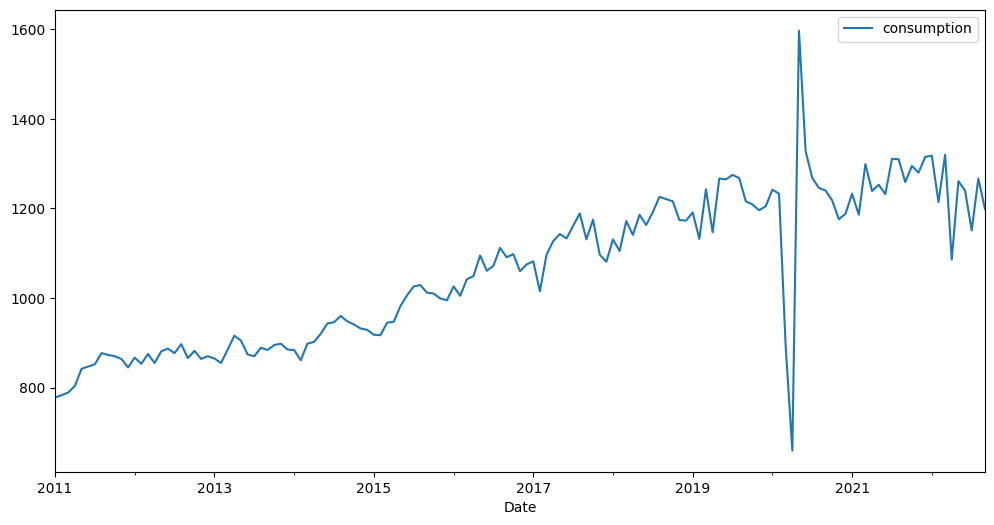

In [517]:
df.plot(figsize=(12,6))

In [518]:
from statsmodels.tsa.seasonal import seasonal_decompose

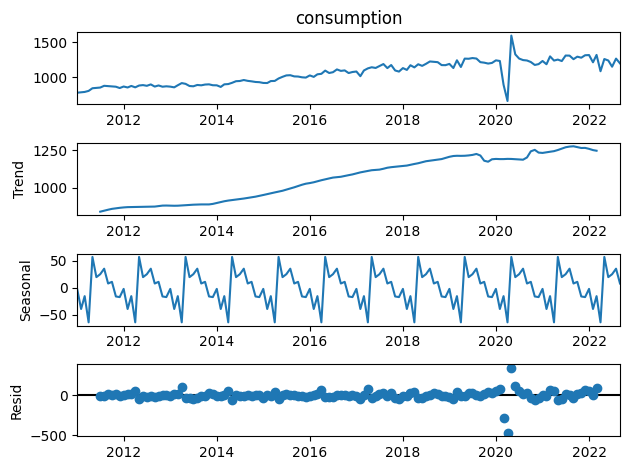

In [519]:
results = seasonal_decompose(df['consumption'])
results.plot();

In [520]:
len(df)

141

In [521]:
train = df.iloc[:100]
test = df.iloc[100:]

In [522]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [523]:
df.head(),df.tail()

(            consumption
 Date                   
 2011-01-01        778.0
 2011-02-01        783.0
 2011-03-01        789.0
 2011-04-01        804.0
 2011-05-01        842.0,
             consumption
 Date                   
 2022-05-01       1261.0
 2022-06-01       1240.0
 2022-07-01       1151.0
 2022-08-01       1267.0
 2022-09-01       1199.0)

In [524]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [525]:
scaled_train[:10]
print(df.dtypes)

consumption    float64
dtype: object


In [526]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [527]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [528]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.01075269 0.02365591 0.05591398 0.13763441 0.1483871
 0.15913978 0.21290323 0.20430108 0.19784946 0.18494624 0.14408602]
Predict this y: 
 [[0.19139785]]


In [529]:
X.shape

(1, 12, 1)

In [530]:

n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [531]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [532]:
# define model

model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(200, activation='relu',input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [533]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 12, 200)           161600    
                                                                 
 lstm_50 (LSTM)              (None, 12, 200)           320800    
                                                                 
 lstm_51 (LSTM)              (None, 200)               320800    
                                                                 
 dense_17 (Dense)            (None, 1)                 201       
                                                                 
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________


In [534]:
# fit model
model.fit(generator,epochs=150)

Epoch 1/150
88/88 [==============================] - 3s 9ms/step - loss: 0.0353
Epoch 2/150
88/88 [==============================] - 1s 9ms/step - loss: 0.0104
Epoch 3/150
88/88 [==============================] - 1s 9ms/step - loss: 0.0086
Epoch 4/150
88/88 [==============================] - 1s 9ms/step - loss: 0.0074
Epoch 5/150
88/88 [==============================] - 1s 9ms/step - loss: 0.0057
Epoch 6/150
88/88 [==============================] - 1s 9ms/step - loss: 0.0067
Epoch 7/150
88/88 [==============================] - 1s 8ms/step - loss: 0.0070
Epoch 8/150
88/88 [==============================] - 1s 9ms/step - loss: 0.0067
Epoch 9/150
88/88 [==============================] - 1s 9ms/step - loss: 0.0059
Epoch 10/150
88/88 [==============================] - 1s 9ms/step - loss: 0.0080
Epoch 11/150
88/88 [==============================] - 1s 10ms/step - loss: 0.0068
Epoch 12/150
88/88 [==============================] - 1s 9ms/step - loss: 0.0051
Epoch 13/150
88/88 [================

Text(0, 0.5, 'Loss')

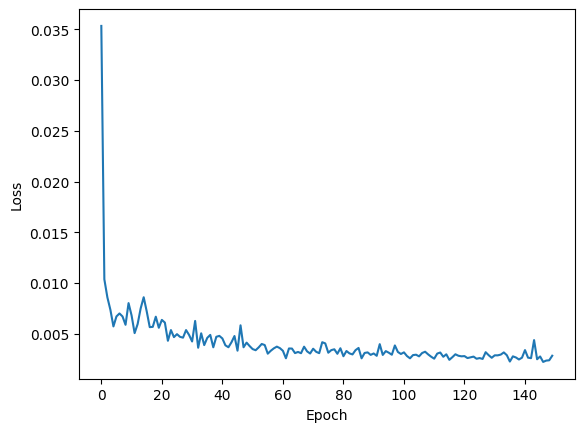

In [535]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [496]:
last_train_batch = scaled_train[-12:]

In [497]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [498]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 233ms/step


array([[0.91468006]], dtype=float32)

In [499]:
scaled_test[0]

array([1.0516129])

In [500]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [501]:
test_predictions

[array([0.91468006], dtype=float32),
 array([0.89324754], dtype=float32),
 array([0.9245144], dtype=float32),
 array([0.9641199], dtype=float32),
 array([0.9564601], dtype=float32),
 array([0.9532578], dtype=float32),
 array([0.902036], dtype=float32),
 array([0.90462416], dtype=float32),
 array([0.9213204], dtype=float32),
 array([0.85309845], dtype=float32),
 array([0.975899], dtype=float32),
 array([0.87321776], dtype=float32),
 array([0.9380893], dtype=float32),
 array([0.9295368], dtype=float32),
 array([0.94441766], dtype=float32),
 array([0.96457636], dtype=float32),
 array([0.95981085], dtype=float32),
 array([0.95915526], dtype=float32),
 array([0.93213004], dtype=float32),
 array([0.93558484], dtype=float32),
 array([0.9414682], dtype=float32),
 array([0.908231], dtype=float32),
 array([0.96778846], dtype=float32),
 array([0.9190442], dtype=float32),
 array([0.95139813], dtype=float32),
 array([0.94825494], dtype=float32),
 array([0.95507497], dtype=float32),
 array([0.964917

In [502]:
test.head()

,consumption
Date,
2019-05-01,1267.0
2019-06-01,1265.0
2019-07-01,1275.0
2019-08-01,1268.0
2019-09-01,1216.0


In [503]:
true_predictions = scaler.inverse_transform(test_predictions)

In [504]:
test['Predictions'] = true_predictions

C:\Users\kasun\AppData\Local\Temp\ipykernel_30576\2515899287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

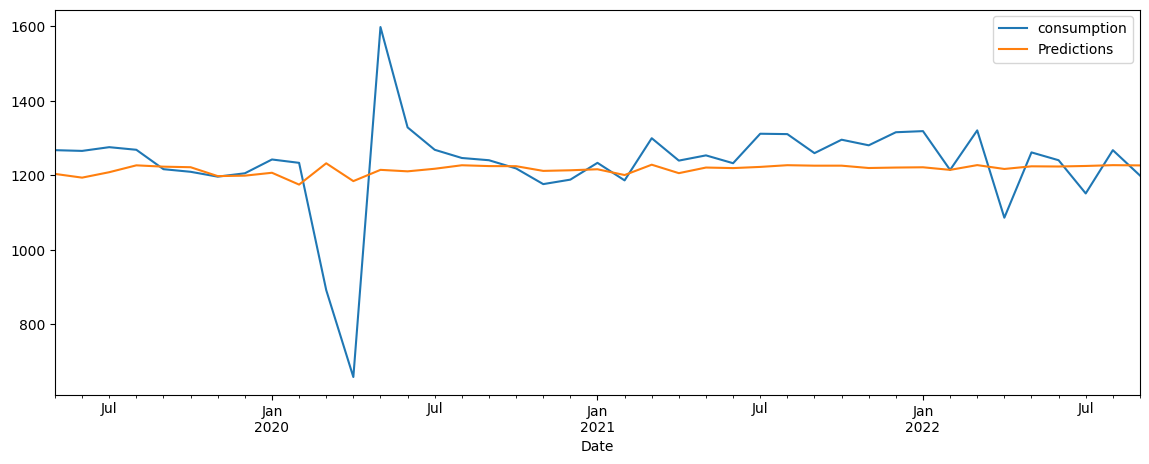

In [505]:
test.plot(figsize=(14,5))

In [506]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['consumption'],test['Predictions']))
print(rmse)

127.15623399365937


In [507]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

# calculate sMAPE
n = len(test)
smape = (1/n) * np.sum(2 * np.abs(test['Predictions'] - test['consumption']) / (np.abs(test['Predictions']) + np.abs(test['consumption']))) * 100
print(f'sMAPE: {smape:.2f}%')

# calculate MAPE
mape = np.mean(np.abs(test['Predictions'] - test['consumption']) / np.abs(test['consumption'])) * 100
print(f'MAPE: {mape:.2f}%')

# calculate MAE
mae = mean_absolute_error(test['consumption'], test['Predictions'])
print(f'MAE: {mae:.2f}')

# calculate RMSE
rmse = np.sqrt(np.mean((test['Predictions'] - test['consumption'])**2))
print(f'RMSE: {rmse:.2f}')

# calculate RMSE percentage
rmse_perc = (rmse / np.mean(test['consumption'])) * 100
print(f'RMSE percentage: {rmse_perc:.2f}%')


sMAPE: 6.31%
MAPE: 6.88%
MAE: 73.44
RMSE: 127.16
RMSE percentage: 10.33%


In [512]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
rmse=sqrt(mean_squared_error(test['consumption'],test['Predictions']))
mse = mean_squared_error(test['consumption'],test['Predictions'])
r2 = r2_score(test['consumption'],test['Predictions'])

print("R-squared:", r2)
print(rmse)
print(mse)

mape = np.mean(np.abs((test['consumption'] -test['Predictions'])  / test['consumption'])) * 100

print("Mean Absolute Percentage Error:", mape)
actual_mean = test['consumption'].mean()
accuracy = (1 - rmse / actual_mean) * 100
print(f"The accuracy of the model is {accuracy:.2f}%")

R-squared: 0.027067194753392032
127.15623399365937
16168.707843450256
Mean Absolute Percentage Error: 6.88464581672559
The accuracy of the model is 89.67%


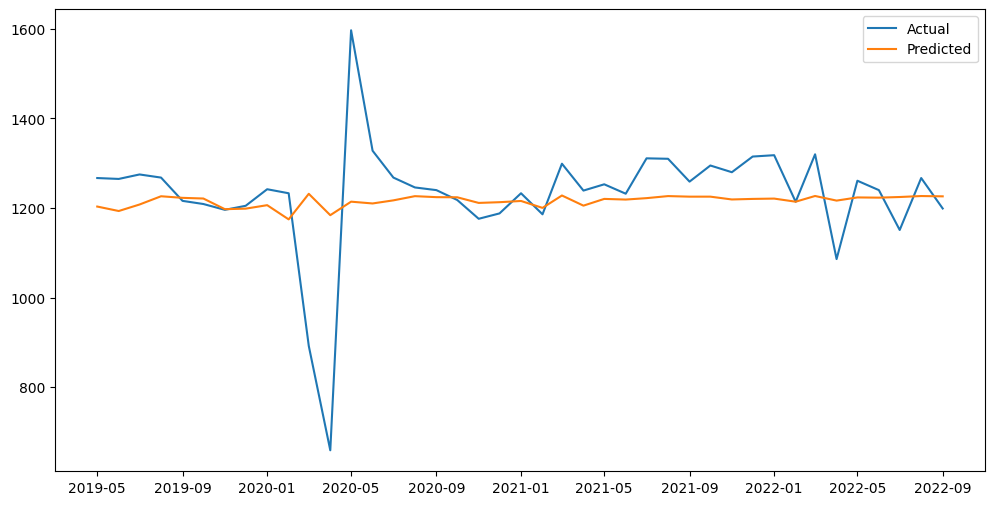

In [508]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test['consumption'], label='Actual')
plt.plot(test.index, test['Predictions'], label='Predicted')
plt.legend()
plt.show()


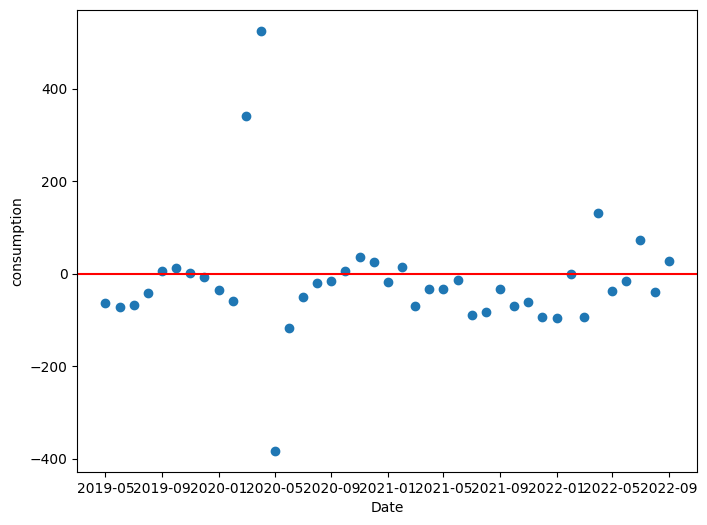

In [509]:
residuals = test['Predictions'] - test['consumption']
plt.figure(figsize=(8,6))
plt.scatter(test.index, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Date')
plt.ylabel('consumption')
plt.show()


In [510]:
# save the model to disk
model.save('consumption_Model_de.h5')


In [511]:
from tensorflow.python.keras.models import model_from_json

# Save the model's architecture as a JSON file
model_json = model.to_json()
with open("consumption_model_de.json", "w") as json_file:
    json_file.write(model_json)

# Save the model's weights as an HDF5 file
model.save_weights("consumption_model_weights_de.h5")

# Load the model's architecture from the JSON file
with open('consumption_model_de.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model's weights from the HDF5 file
loaded_model.load_weights("consumption_model_weights_de.h5")

# Compile the loaded model before using it
loaded_model.compile(optimizer='adam', loss='mse')


In [385]:
import numpy as np
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler
# Load the model's architecture from the JSON file
with open('consumption_model_de.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model's weights from the HDF5 file
loaded_model.load_weights("consumption_model_weights_de.h5")

# Compile the loaded model before using it
loaded_model.compile(optimizer='adam', loss='mse')

# Define the 12 past month values
past_data = [31339465,32216079,28354187,29965163,27469754,30176368,35585347,40269224,39320309,34929664,31157491,29139490,31739196]
# Reshape the example data into a 2D array with one column
example_data = np.array(past_data).reshape(-1, 1)
# create the scaler object
scaler = MinMaxScaler()

# fit the scaler object on the training data
scaler.fit(example_data)

# transform the training and testing data using the fitted scaler
scaled_test = scaler.transform(example_data)


# Generate a sequence of input data for the model to make a prediction on
n_input = 12
generator = TimeseriesGenerator(scaled_test, scaled_test, length=12, batch_size=1)
# Get the input sequence for the first batch
X, y = generator[0]

# Reshape the data to match the input shape of the model
X = X.reshape((1, 12, 1))

# Make a prediction using the loaded model
prediction = loaded_model.predict(X)

# Inverse transform the prediction to get the actual scale
actual_prediction = scaler.inverse_transform(prediction)

print("Prediction:", actual_prediction[0][0])


1/1 [==============================] - 0s 262ms/step
Prediction: 32517354.0


In [386]:
import numpy as np
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

# Load the model's architecture from the JSON file
with open('model_de.json', 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model's weights from the HDF5 file
loaded_model.load_weights("model_weights_de.h5")

# Compile the loaded model before using it
loaded_model.compile(optimizer='adam', loss='mse')

# Define the past month values for which we want to make a prediction
past_data = [31339465, 32216079, 28354187, 29965163, 27469754, 30176368, 35585347, 40269224, 39320309, 34929664, 31157491, 29139490, 31739196]

# Reshape the example data into a 2D array with one column
example_data = np.array(past_data).reshape(-1, 1)

# Create a MinMaxScaler object to scale the data between 0 and 1
scaler = MinMaxScaler()

# Fit the scaler object on the example data
scaler.fit(example_data)

# Transform the example data using the fitted scaler
scaled_example_data = scaler.transform(example_data)

# Generate a sequence of input data for the model to make a prediction on
n_input = 12
generator = TimeseriesGenerator(scaled_example_data, scaled_example_data, length=n_input, batch_size=1)

# Get the input sequence for the first batch
X, y = generator[0]

# Reshape the data to match the input shape of the model
X = X.reshape((1, n_input, 1))

# Make a prediction using the loaded model
prediction = loaded_model.predict(X)

# Inverse transform the prediction to get the actual scale
actual_prediction = scaler.inverse_transform(prediction)

# Print the predicted value
print("Prediction:", actual_prediction[0][0])


1/1 [==============================] - 0s 248ms/step
Prediction: 32517354.0
